# initial-model

This notebook is the prototype build for the initial model. The intent is getting something working; there may be some not-niceness involved which will be cleaned up in future iterations.

Credit where credit is due, this model is a rewrite of [BERT Base Uncased using PyTorch](https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch/).

## data exploration

https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch

In [1]:
import pandas as pd
train = pd.read_csv("/mnt/tweet-sentiment-extraction/train.csv")

In [2]:
train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


Notes on some lessons learned during the replication process.

1. > You're attempting to predict the word or phrase from the tweet that exemplifies the provided sentiment.
  
  So `text` and `sentiment` are inputs, `selected_text` is the target. `selected_text` is a sub-sentence fragment.
  
  It's not immediately obvious to me how you would modify the design of the neural network to achieve this, so this is a good exercise in network architecture imagination besides.
2. There are two interfaces to language encoders in the `huggingface` ecosystem: `tokenizers`, the low-level library, and `transformers`, the original library.
  
  The `transformers` interface lets you instantiate a pretrained network without having to download the dataset, but does not offer an interface to any of the methods besides the output tokens themselves. 
  
  The `tokenizers` interface forces you to have the whole thing on disk, but exposes a richer underlying API. This model uses this underlying API, so we will have to do things this way.
3. `transformers` models let you swap to the version of the BERT model trained (fine-tuned?) on question-answer pairs transparently by setting the `token_type_ids` property on the model. We're adapting question-answering to this task by cleverly encoding the input records as a `sentiment:tweet` pair and using a custom head for outputting logits for each element of the output sentence.

## prototype data part

In [3]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
from collections import namedtuple

In [4]:
def process_data(tweet, selected_text, sentiment, tokenizer, max_len):
    # yes this really happens lol, try idx 314
    if pd.isnull(tweet) or pd.isnull(selected_text) or len(tweet) == 0 or len(selected_text) == 0:
        raise ValueError("text or selected_text is nan.")
    
    # get indicial boundaries of substring.
    target_char_idx_start = tweet.index(selected_text)
    target_char_idx_end = target_char_idx_start + len(selected_text)

    # build the character attention mask (used to build the token attention mask)
    char_target_mask = (
        [0] * target_char_idx_start +
        [1] * (target_char_idx_end - target_char_idx_start) +
        [0] * (len(tweet) - target_char_idx_end)
    )
    
    # tokenize
    # `ids` is the token values, `offsets` are the position tuples for the tokes in the str
    tokens_obj = tokenizer.encode(tweet)
    token_ids, token_offsets = tokens_obj.ids, tokens_obj.offsets
    
    # this is the clever bit. recall that the task is to find the subsequence in the sequence
    # exemplifying the given sentiment. to do this we reformulate the input sequence as a
    # question-answer pair, where the sentiment (as a single word) is the question and the
    # sequence as a whole is the answer.
    # 
    # this allows us to use version of the BERT model pretrained on the well-formed and
    # well-studied question-answering task as a surrogate for this task.
    sentiment_id_map = {
        'positive': 3893,
        'negative': 4997,
        'neutral': 8699
    }
    # 101 is [CLS] and 102 is [SEP]. BERT expects Q/A input to be in the form
    # [CLS] [...] [SEP] [...] [SEP]. Cf.
    # https://huggingface.co/transformers/glossary.html#token-type-ids
    # NOTE: the [-1:1] is the excise the start-of-seq and end-of-seq in the tokens
    input_ids = [101] + [sentiment_id_map[sentiment]] + [102] + token_ids[1:-1] + [102]
    
    # BERT expects Q/A pairs to come with a binary mask splitting the pair types
    # NOTE: the mafs excludes start-of-seq and end-of-seq but includes the new end-of-seq
    token_type_ids = [0, 0, 0] + [1] * (len(token_ids) - 2 + 1)

    # pad to max_len and create a corresponding attention mask
    pad_len = max_len - len(input_ids)
    attention_mask = [1] * len(input_ids) + [0] * pad_len
    input_ids = input_ids + [0] * pad_len
    token_type_ids = token_type_ids + [0] * pad_len
    
    # get the index of the first and last token of the target, this is what the model will try
    # to predict! see the notes on the head layer in forward for more info.
    # we add 3 because the first thee elements of the mask are always [CLS] $SENTIMENT [CLS]
    # and always get an attention vector [1 1 1].
    ufunc = lambda first, _: first >= target_char_idx_start and first < target_char_idx_end
    y_pred_mask = [ufunc(*offset) for offset in token_offsets]
    try:
        y_first = 3 + y_pred_mask.index(True)
        y_last = 3 + len(y_pred_mask) - y_pred_mask[::-1].index(True) - 1
    except ValueError:
        # some of the labels are noisy, and the first character in the label does not actually
        # correspond with the first character of any token (e.g. the label is a part-of-a-word
        # instead of a word). I'm going to venture the opinion here that these records 
        # constitute data noise (because, I mean, they are) and should be removed in
        # pre-processing
        raise ValueError(
            f"Found bad selected_text value '{selected_text}' for tweet '{tweet}'."
            f"Make sure to get rid of these in a pre-processing pass."
        )
    
    # convert to torch tensors
    t = lambda seq: torch.tensor(seq, dtype=torch.long)
    input_ids, token_type_ids, attention_mask, y_first, y_last =\
        t(input_ids), t(token_type_ids), t(attention_mask), t(y_first), t(y_last)
    
    # output
    # Unfortunately the PyTorch dataloader relies on pickle, and TIL namedtuples do not play nice
    # with pickle!
    # Record = namedtuple('record', 'input_ids token_type_ids attention_mask y_first y_last')
    # return Record(input_ids, token_type_ids, attention_mask, y_first, y_last)
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask,
        "y_first": y_first,
        "y_last": y_last
    }

class TwitterSentimentExtractionDataset:
    def __init__(self, df):
        self.df = df
        self.tokenizer = tokenizers.BertWordPieceTokenizer(
            f"/mnt/bert-base-uncased/vocab.txt", lowercase=True
        )
        self.max_len = 128
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        return process_data(
            self.df.text[item],
            self.df.selected_text[item], 
            self.df.sentiment[item],
            self.tokenizer,
            self.max_len
        )

In [7]:
# preprocessing pass; see comments in the previous code cell on why this is necessary
X_train_preprocessing_pass = TwitterSentimentExtractionDataset(train)

import tqdm
bad_idxs, good_idxs, y_firsts, y_lasts = [], [], [], []
for i in tqdm.tqdm(list(range(len(train)))):
    try:
        x = X_train_preprocessing_pass[i]
        y_firsts.append(x['y_first'])
        y_lasts.append(x['y_last'])
        good_idxs.append(i)
    except ValueError:
        print(f"Found bad record at idx {i}.")
        y_firsts.append(None)
        y_lasts.append(None)
        bad_idxs.append(i)

del X_train_preprocessing_pass

  3%|▎         | 823/27481 [00:00<00:06, 4095.18it/s]

Found bad record at idx 18.
Found bad record at idx 314.


 21%|██▏       | 5875/27481 [00:01<00:05, 4136.52it/s]

Found bad record at idx 5436.


 33%|███▎      | 9188/27481 [00:02<00:04, 4102.30it/s]

Found bad record at idx 8729.


 46%|████▌     | 12582/27481 [00:03<00:03, 4199.90it/s]

Found bad record at idx 11808.
Found bad record at idx 12405.


 53%|█████▎    | 14702/27481 [00:03<00:03, 4232.25it/s]

Found bad record at idx 14172.


 58%|█████▊    | 15976/27481 [00:03<00:02, 4193.28it/s]

Found bad record at idx 15207.


 83%|████████▎ | 22764/27481 [00:05<00:01, 3853.50it/s]

Found bad record at idx 21983.


 94%|█████████▎| 25698/27481 [00:06<00:00, 4150.74it/s]

Found bad record at idx 24929.


100%|██████████| 27481/27481 [00:06<00:00, 4118.03it/s]


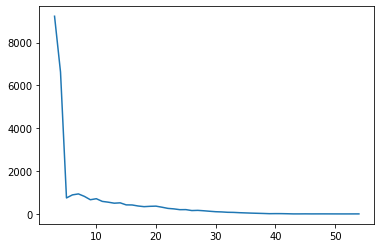

In [8]:
pd.Series(y_firsts).map(lambda v: v.item() if v else None).value_counts().sort_index().plot.line()

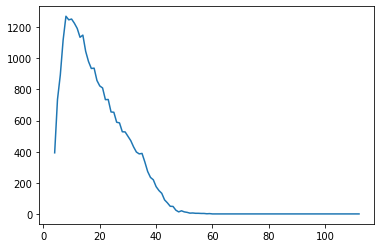

In [9]:
pd.Series(y_lasts).map(lambda v: v.item() if v else None).value_counts().sort_index().plot.line()

In [10]:
# recall the two rubbish cases: NaN values and selected texts not corresponding with token starts
train.iloc[bad_idxs]

,textID,text,selected_text,sentiment
18,af3fed7fc3,is back home now gonna miss every one,onna,negative
314,fdb77c3752,NaN,NaN,neutral
5436,780c673bca,going out for the good ol` `soak` tonight for ...,ing,positive
8729,12f21c8f19,star wars ............ is **** BOO??? i wanna...,l,positive
11808,96ff964db0,"4 hours of sleep, a migraine, again? What is w...",hat,negative
12405,df398a774e,"alright...I`m going to get off comp now, go ...",ave,positive
14172,c155efab1b,Hey Honey Bunny here big bunny hugs,unny,positive
15207,4b3fd4ec22,Last day at DMA over! a million sad faces.,ion,negative
21983,4c279acff6,"why? i enjoy fancy meals on my own smtimes, t...",joy,positive
24929,09d0f8f088,two macaroons go into a bar....one says oh yo...,wo,positive


In [11]:
train_orig = train
X_train_df = train.iloc[good_idxs].reset_index(drop=True)

## prototype model part

In [12]:
class TwitterSentimentExtractionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # configuring the model to output hidden states
        cfg = transformers.PretrainedConfig.get_config_dict("bert-base-uncased")[0]  # tuple?
        cfg["output_hidden_states"] = True
        cfg = transformers.BertConfig.from_dict(cfg)
        self.bert = transformers.BertModel.from_pretrained("bert-base-uncased", config=cfg)
        
        self.drop_out = nn.Dropout(0.1)
        self.l0 = nn.Linear(768 * 2, 2)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        # self.out = nn.LogSoftmax(dim=-2)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        # ignore the output from the model head, we'll instead we'll construct our own attention
        # head connected to the last two layers of hidden weights.
        # that's 512x762x2=780288 connections.
        _, _, out = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        out = torch.cat((out[-1], out[-2]), dim=-1)
        out = self.drop_out(out)
        # the new head uses a linear layer with two output nodes.
        # the first node learns sequence start.
        # the second node learns sequence end.
        logits = self.l0(out)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        
        return start_logits, end_logits
        
        # TODO: embed softmax directly into the model arch
        # y_start, y_end = self.out(start_logits), self.out(end_logits)
        # return y_start, y_end

In [13]:
# try it

dataset = TwitterSentimentExtractionDataset(X_train_df)
model = TwitterSentimentExtractionModel()
ex = dataset[0]
ex_input_ids, ex_attention_mask, ex_token_type_ids =\
    ex['input_ids'][None,:], ex['attention_mask'][None,:], ex['token_type_ids'][None,:]

result = model(ex_input_ids, ex_attention_mask, ex_token_type_ids)

In [14]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    ce = nn.CrossEntropyLoss()
    y_pred_first_loss = ce(start_logits, start_positions)
    y_pred_last_loss = ce(end_logits, end_positions)
    y_pred_loss = (y_pred_first_loss + y_pred_last_loss)
    return y_pred_loss

In [15]:
# try it

# loss_fn(result[0], result[1], torch.tensor([1]), torch.tensor([5]))

tensor(9.6803, grad_fn=<AddBackward0>)

In [16]:
# try it

X_train = TwitterSentimentExtractionDataset(X_train_df)
X_train_dataloader = torch.utils.data.DataLoader(
    X_train,
    batch_size=64,
    num_workers=1
)
iter(X_train_dataloader).next()

{'input_ids': tensor([[ 101, 8699,  102,  ...,    0,    0,    0],
         [ 101, 4997,  102,  ...,    0,    0,    0],
         [ 101, 4997,  102,  ...,    0,    0,    0],
         ...,
         [ 101, 4997,  102,  ...,    0,    0,    0],
         [ 101, 3893,  102,  ...,    0,    0,    0],
         [ 101, 4997,  102,  ...,    0,    0,    0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'y_first': tensor([ 4,  4,  7,  7,  4,  3, 12,  3,  4,  7,  4,  7,  9, 13,  3,  3, 15,  8,
          3,  4,  9,  3,  3,  3,  3,  4, 11, 18, 16, 19,  5, 24,  8,  4, 

## prototype training loop

In [20]:
# create model
device = torch.device("cuda")

model = TwitterSentimentExtractionModel()
model.to(device)
pass

In [18]:
# create optimizer; uses weight decay
model_parameters = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in model_parameters if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in model_parameters if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
optimizer = AdamW(optimizer_parameters, lr=3e-5)

In [76]:
# batch size and epochs globals; setting batch_size = 1 for testing, 64 is too much for the K80
batch_size = 1
# batch_size = 64
epochs = 5

In [77]:
# dataset and dataloader
dataset = TwitterSentimentExtractionDataset(X_train_df)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1
)

In [42]:
# create scheduler, this one is a transformers module hookup, thanks huggingface
num_train_steps = int(len(dataloader) * epochs)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

In [57]:
# train func for one epoch of training
def train_fn(dataloader, model, optimizer, device, scheduler, epoch_num):
    model.train()
    
    losses = []
    fn = lambda field: records[field].to(device, dtype=torch.long)
    for idx, records in enumerate(dataloader):
        # move the record to GPU
        input_ids = fn("input_ids")
        token_type_ids = fn("token_type_ids")
        attention_mask = fn("attention_mask")
        y_first = fn("y_first")
        y_last = fn("y_last")
        
        model.zero_grad()
        y_pred_start_logits, y_pred_end_logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        loss = loss_fn(y_pred_start_logits, y_pred_end_logits, y_first, y_last)
        loss.backward()
        optimizer.step()
        scheduler.step()

        y_pred_starts = torch.softmax(y_pred_start_logits, dim=1).cpu().detach().numpy()
        y_pred_ends = torch.softmax(y_pred_end_logits, dim=1).cpu().detach().numpy()
        losses.append(loss.item())
        
        if idx % 10 == 0:
            print(f"epoch {epoch_num}, batch {idx} training loss: {losses[-1]}")
        
        break

    return losses

In [59]:
# try it; note, first you should unhide the break

train_fn(dataloader, model, optimizer, device, scheduler, 1)

epoch 1, batch 0 training loss: 9.667827606201172


[9.667827606201172]

In [79]:
def main():
    checkpoints_dir = "/spell/checkpoints/"
    if not os.path.exists(checkpoints_dir):
        os.mkdir(checkpoints_dir)
    
    for epoch in range(1, epochs + 1):
        train_fn(dataloader, model, optimizer, device, scheduler, epoch)
        torch.save(model.state_dict(), f"/spell/checkpoints/model_{epoch}.pth")

## write model definition to disk

In [63]:
!mkdir ../models/

In [83]:
%%writefile ../models/model_1.py
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
# from sklearn import model_selection
# from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
from collections import namedtuple

train = pd.read_csv("/mnt/tweet-sentiment-extraction/train.csv")
def process_data(tweet, selected_text, sentiment, tokenizer, max_len):
    # yes this really happens lol, try idx 314
    if pd.isnull(tweet) or pd.isnull(selected_text) or len(tweet) == 0 or len(selected_text) == 0:
        raise ValueError("text or selected_text is nan.")
    
    # get indicial boundaries of substring.
    target_char_idx_start = tweet.index(selected_text)
    target_char_idx_end = target_char_idx_start + len(selected_text)

    # build the character attention mask (used to build the token attention mask)
    char_target_mask = (
        [0] * target_char_idx_start +
        [1] * (target_char_idx_end - target_char_idx_start) +
        [0] * (len(tweet) - target_char_idx_end)
    )
    
    # tokenize
    # `ids` is the token values, `offsets` are the position tuples for the tokes in the str
    tokens_obj = tokenizer.encode(tweet)
    token_ids, token_offsets = tokens_obj.ids, tokens_obj.offsets
    
    # this is the clever bit. recall that the task is to find the subsequence in the sequence
    # exemplifying the given sentiment. to do this we reformulate the input sequence as a
    # question-answer pair, where the sentiment (as a single word) is the question and the
    # sequence as a whole is the answer.
    # 
    # this allows us to use version of the BERT model pretrained on the well-formed and
    # well-studied question-answering task as a surrogate for this task.
    sentiment_id_map = {
        'positive': 3893,
        'negative': 4997,
        'neutral': 8699
    }
    # 101 is [CLS] and 102 is [SEP]. BERT expects Q/A input to be in the form
    # [CLS] [...] [SEP] [...] [SEP]. Cf.
    # https://huggingface.co/transformers/glossary.html#token-type-ids
    # NOTE: the [-1:1] is the excise the start-of-seq and end-of-seq in the tokens
    input_ids = [101] + [sentiment_id_map[sentiment]] + [102] + token_ids[1:-1] + [102]
    
    # BERT expects Q/A pairs to come with a binary mask splitting the pair types
    # NOTE: the mafs excludes start-of-seq and end-of-seq but includes the new end-of-seq
    token_type_ids = [0, 0, 0] + [1] * (len(token_ids) - 2 + 1)

    # pad to max_len and create a corresponding attention mask
    pad_len = max_len - len(input_ids)
    attention_mask = [1] * len(input_ids) + [0] * pad_len
    input_ids = input_ids + [0] * pad_len
    token_type_ids = token_type_ids + [0] * pad_len
    
    # get the index of the first and last token of the target, this is what the model will try
    # to predict! see the notes on the head layer in forward for more info.
    # we add 3 because the first thee elements of the mask are always [CLS] $SENTIMENT [CLS]
    # and always get an attention vector [1 1 1].
    ufunc = lambda first, _: first >= target_char_idx_start and first < target_char_idx_end
    y_pred_mask = [ufunc(*offset) for offset in token_offsets]
    try:
        y_first = 3 + y_pred_mask.index(True)
        y_last = 3 + len(y_pred_mask) - y_pred_mask[::-1].index(True) - 1
    except ValueError:
        # some of the labels are noisy, and the first character in the label does not actually
        # correspond with the first character of any token (e.g. the label is a part-of-a-word
        # instead of a word). I'm going to venture the opinion here that these records 
        # constitute data noise (because, I mean, they are) and should be removed in
        # pre-processing
        raise ValueError(
            f"Found bad selected_text value '{selected_text}' for tweet '{tweet}'."
            f"Make sure to get rid of these in a pre-processing pass."
        )
    
    # convert to torch tensors
    t = lambda seq: torch.tensor(seq, dtype=torch.long)
    input_ids, token_type_ids, attention_mask, y_first, y_last =\
        t(input_ids), t(token_type_ids), t(attention_mask), t(y_first), t(y_last)
    
    # output
    # Unfortunately the PyTorch dataloader relies on pickle, and TIL namedtuples do not play nice
    # with pickle!
    # Record = namedtuple('record', 'input_ids token_type_ids attention_mask y_first y_last')
    # return Record(input_ids, token_type_ids, attention_mask, y_first, y_last)
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask,
        "y_first": y_first,
        "y_last": y_last
    }

class TwitterSentimentExtractionDataset:
    def __init__(self, df):
        self.df = df
        self.tokenizer = tokenizers.BertWordPieceTokenizer(
            f"/mnt/bert-base-uncased/vocab.txt", lowercase=True
        )
        self.max_len = 128
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        return process_data(
            self.df.text[item],
            self.df.selected_text[item], 
            self.df.sentiment[item],
            self.tokenizer,
            self.max_len
        )

# preprocessing pass; see comments in the previous code cell on why this is necessary
X_train_preprocessing_pass = TwitterSentimentExtractionDataset(train)

bad_idxs, good_idxs, y_firsts, y_lasts = [], [], [], []
for i in range(len(train)):
# for i in tqdm.tqdm(list(range(len(train)))):
    try:
        x = X_train_preprocessing_pass[i]
        y_firsts.append(x['y_first'])
        y_lasts.append(x['y_last'])
        good_idxs.append(i)
    except ValueError:
        print(f"Found bad record at idx {i}.")
        y_firsts.append(None)
        y_lasts.append(None)
        bad_idxs.append(i)

del X_train_preprocessing_pass
train_orig = train
X_train_df = train.iloc[good_idxs].reset_index(drop=True)

class TwitterSentimentExtractionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # configuring the model to output hidden states
        cfg = transformers.PretrainedConfig.get_config_dict("bert-base-uncased")[0]  # tuple?
        cfg["output_hidden_states"] = True
        cfg = transformers.BertConfig.from_dict(cfg)
        self.bert = transformers.BertModel.from_pretrained("bert-base-uncased", config=cfg)
        
        self.drop_out = nn.Dropout(0.1)
        self.l0 = nn.Linear(768 * 2, 2)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        # self.out = nn.LogSoftmax(dim=-2)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        # ignore the output from the model head, we'll instead we'll construct our own attention
        # head connected to the last two layers of hidden weights.
        # that's 512x762x2=780288 connections.
        _, _, out = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        out = torch.cat((out[-1], out[-2]), dim=-1)
        out = self.drop_out(out)
        # the new head uses a linear layer with two output nodes.
        # the first node learns sequence start.
        # the second node learns sequence end.
        logits = self.l0(out)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        
        return start_logits, end_logits
        
        # TODO: embed softmax directly into the model arch
        # y_start, y_end = self.out(start_logits), self.out(end_logits)
        # return y_start, y_end

def loss_fn(start_logits, end_logits, start_positions, end_positions):
    ce = nn.CrossEntropyLoss()
    y_pred_first_loss = ce(start_logits, start_positions)
    y_pred_last_loss = ce(end_logits, end_positions)
    y_pred_loss = (y_pred_first_loss + y_pred_last_loss)
    return y_pred_loss

# create model
device = torch.device("cuda")

model = TwitterSentimentExtractionModel()
model.to(device)

# create optimizer; uses weight decay
model_parameters = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in model_parameters if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in model_parameters if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
optimizer = AdamW(optimizer_parameters, lr=3e-5)

# batch size and epochs globals; setting batch_size = 1 for testing, 64 is too much for the K80
batch_size = 64
epochs = 5

# dataset and dataloader
dataset = TwitterSentimentExtractionDataset(X_train_df)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1
)

# create scheduler, this one is a transformers module hookup, thanks huggingface
num_train_steps = int(len(dataloader) * epochs)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

# train func for one epoch of training
def train_fn(dataloader, model, optimizer, device, scheduler, epoch_num):
    model.train()
    
    losses = []
    fn = lambda field: records[field].to(device, dtype=torch.long)
    for idx, records in enumerate(dataloader):
        # move the record to GPU
        input_ids = fn("input_ids")
        token_type_ids = fn("token_type_ids")
        attention_mask = fn("attention_mask")
        y_first = fn("y_first")
        y_last = fn("y_last")
        
        model.zero_grad()
        y_pred_start_logits, y_pred_end_logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        loss = loss_fn(y_pred_start_logits, y_pred_end_logits, y_first, y_last)
        loss.backward()
        optimizer.step()
        scheduler.step()

        y_pred_starts = torch.softmax(y_pred_start_logits, dim=1).cpu().detach().numpy()
        y_pred_ends = torch.softmax(y_pred_end_logits, dim=1).cpu().detach().numpy()
        losses.append(loss.item())
        
        if idx % 10 == 0:
            print(f"epoch {epoch_num}, batch {idx} training loss: {losses[-1]}")

    return losses


def main():
    checkpoints_dir = "/spell/checkpoints/"
    if not os.path.exists(checkpoints_dir):
        os.mkdir(checkpoints_dir)
    
    for epoch in range(1, epochs + 1):
        train_fn(dataloader, model, optimizer, device, scheduler, epoch)
        torch.save(model.state_dict(), f"/spell/checkpoints/model_{epoch}.pth")

if __name__ == "__main__":
    main()

Overwriting ../models/model_1.py


In [74]:
os.path.exists("/spell/checkpoints/")

True

In [73]:
os.mkdir("/spell/checkpoints/")